# SpatialDE Analysis

In [1]:
import numpy as np
import pandas as pd
import NaiveDE
import SpatialDE
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm

## Import Datasets

In [2]:
def T_quality(x):
    return np.clip(1-np.log(1+x)/3.9,0,1)


Q_th = 2
min_count = 500
barcodes_df = []
tagList_df = pd.read_csv("../data/tagList_84-gene.csv", sep = ",", usecols = [0,1], header = None, names = ["Seq","Gene"])
datasets = ['170315_161220_4_1','161230_161220_3_1']
for sample in datasets:
    df = pd.read_csv("../data/results/"+sample+"/barcodes.csv", sep = ",")
    df.seq_quality_min=df.seq_quality_min*df.max_dist.apply(T_quality)
    # Add gene names to dataframe
    d = pd.Series(tagList_df.Gene.values,index=tagList_df.Seq).to_dict()
    df["Gene"] = df['letters'].map(d)
    # Downsample barcode coordinate space by factor 8 for easier visualization
    df["global_X_pos"]=df.global_X_pos/8
    df["global_Y_pos"]=df.global_Y_pos/8
    # Remove reads not in the codebook
    df = df.dropna()
    # Filter reads by quality
    df = df[df.seq_quality_min>Q_th]
    # Filter reads by min count per gene
    df["count"] = 0
    for i,row in tagList_df.iterrows():
        df.loc[df["Gene"] == tagList_df.Gene[i],["count"]] = len(df[df["Gene"] == tagList_df.Gene[i]])
    df = df[df["count"]>min_count]
    
    barcodes_df.append(df)

## Generate Expression Tables

In [3]:
# Import and downsample by factor 8 image shape
img_shape = np.round(np.array([[22508, 33566],[22563, 31782]])/8).astype(np.uint)

# Create gene expression table
expression_df = []
for s_idx, df in enumerate(barcodes_df):
    x_min = 0; x_max= img_shape[s_idx,1];
    y_min = 0; y_max= img_shape[s_idx,0];
    batch_size_px=64
    overlap = 8

    express_table = pd.DataFrame(data={}, columns=df.Gene.unique(), index=list((str(x)+"x"+str(y)) for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px))) 
    for i in tqdm(range(x_min,x_max,batch_size_px)):
        for j in range(y_min,y_max,batch_size_px):
            batch_df=df[(df.global_X_pos>=i-(batch_size_px/2)-overlap) & (df.global_X_pos<i+(batch_size_px/2)+overlap) & (df.global_Y_pos>=j-(batch_size_px/2)-overlap) & (df.global_Y_pos<j+(batch_size_px/2)+overlap)]
            if len(batch_df):
                batch_counts = batch_df['Gene'].value_counts()
                express_table.loc[str(i)+'x'+str(j),batch_counts.index]=batch_counts
                
    express_table = express_table.fillna(0)
    
    expression_df.append(express_table)

100%|██████████| 63/63 [01:00<00:00,  1.25it/s]


In [4]:
# save dataframes
for i,dataset in enumerate(datasets):
    expression_df[i].to_pickle('../data/results/'+dataset+'/SpatialDE_express_table.hdf5')

/home/gapartel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/gapartel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


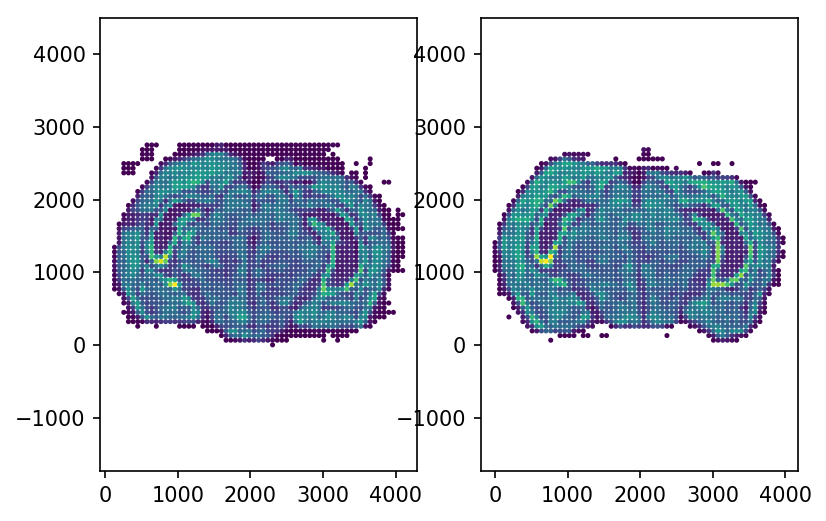

In [5]:
# load dataframes
img_shape = np.round(np.array([[22508, 33566],[22563, 31782]])/8).astype(np.uint)
expression_df = []
sample_df = []
for i,dataset in enumerate(datasets):
    plt.rcParams["figure.dpi"] = 150
    plt.subplot(1,2,i+1)    
    
    x_min = 0; x_max= img_shape[i,1];
    y_min = 0; y_max= img_shape[i,0];
    batch_size_px=16
    overlap = 16
    express_table = pd.read_pickle('../data/results/'+dataset+'/SpatialDE_express_table.hdf5')
    # Create sample_info
    sample_info = pd.DataFrame(data={'x':list(x for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)), 'y':list(y for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px))}, index=list((str(x)+"x"+str(y)) for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)))
    sample_info['total_counts'] = express_table.sum(axis=1)
    # Dropping empty batches
    express_table = express_table[sample_info.total_counts>10]
    sample_info = sample_info[sample_info.total_counts>10]
    
    expression_df.append(express_table)
    expression_df[i] = expression_df[i].rename(('{}_'+str(i)).format)

    sample_df.append(sample_info)
    sample_df[i] = sample_df[i].rename(('{}_'+str(i)).format)
    sample_df[i]['s'] = i
    plt.scatter(sample_df[i]['x'], sample_df[i]['y'], c=sample_df[i]['total_counts'],s=2);
    plt.axis('equal');

## Normalize Gene Expression Tables

In [6]:
expression_df=pd.concat(expression_df,sort=True)
expression_df=expression_df.dropna(axis=1)
#expression_df=expression_df.fillna(0)
sample_df=pd.concat(sample_df,sort=True)
                    
# Linear regression to account for library size and sequencing depth bias of each patch of gene expression
norm_expr = pd.concat([NaiveDE.stabilize(expression_df[sample_df.s==0].T).T,NaiveDE.stabilize(expression_df[sample_df.s==1].T).T])
resid_expr = pd.concat([NaiveDE.regress_out(sample_df[sample_df.s==0], norm_expr[sample_df.s==0].T, 'np.log(total_counts)').T,NaiveDE.regress_out(sample_df[sample_df.s==1], norm_expr[sample_df.s==1].T, 'np.log(total_counts)').T])
idx = resid_expr.var().sort_values(ascending=False).index

## SpatialDE significance test 

In [7]:
results = []
for i,df in enumerate(datasets):
    X = sample_df.loc[sample_df.s==i,['x', 'y']]
    results.append(SpatialDE.run(X, resid_expr.loc[sample_df[sample_df.s==i].index,:]))

In [8]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
display_side_by_side(results[0].sort_values('qval').head(10)[['g', 'l', 'qval']],results[1].sort_values('qval').head(10)[['g', 'l', 'qval']])

,g,l,qval
0,Adgrl2,59.483112,0.0
51,Gap43,110.570018,0.0
50,Gad1,110.570018,0.0
49,Gabrd,110.570018,0.0
48,Fxyd6,110.570018,0.0
47,Cux2,110.570018,0.0
46,Crym,110.570018,0.0
52,Gda,110.570018,0.0
45,Crhbp,110.570018,0.0
43,Chrm2,110.570018,0.0


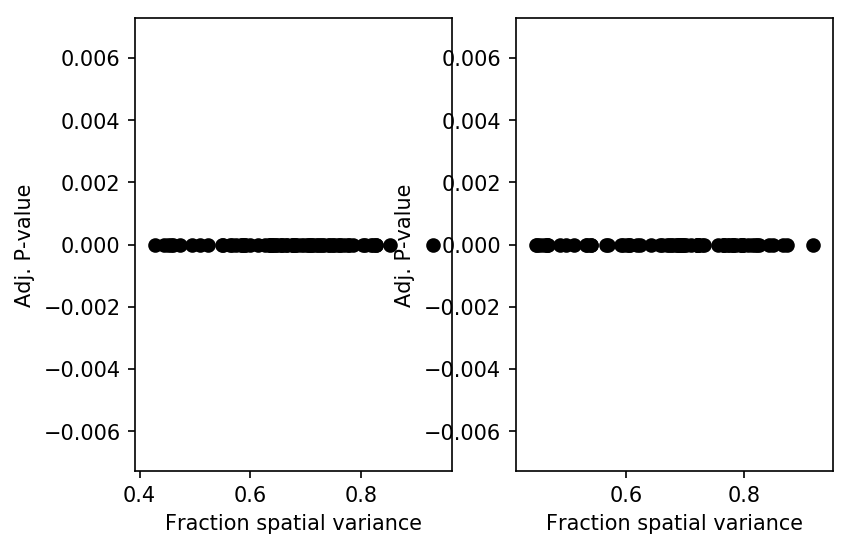

In [9]:
for i,df in enumerate(datasets):
    plt.subplot(1,2,i+1)
    plt.scatter(results[i]['FSV'], results[i]['qval'], c='black')
    plt.xlabel('Fraction spatial variance')
    plt.ylabel('Adj. P-value');

## Automatic expression histology

In [10]:
res = []
n_patterns = 20
for i,df in enumerate(datasets):
    sign_results = results[i].query('qval < 0.05')
    X = sample_df.loc[sample_df.s==i,['x', 'y']]
    histology_results, patterns = SpatialDE.aeh.spatial_patterns(X, resid_expr.loc[sample_df[sample_df.s==i].index,:], sign_results, C=n_patterns, l=results[i].l.mean(), verbosity=1)
    res.append({'aeh': histology_results, 'patterns':patterns})

iter 0, ELBO: -2.23e+08
iter 1, ELBO: -1.13e+08, delta_ELBO: 1.11e+08
iter 2, ELBO: -1.13e+08, delta_ELBO: 2.64e+04
iter 3, ELBO: -1.13e+08, delta_ELBO: 1.44e+04
iter 4, ELBO: -1.13e+08, delta_ELBO: 2.46e+03
iter 5, ELBO: -1.13e+08, delta_ELBO: 2.18e+03
iter 6, ELBO: -1.13e+08, delta_ELBO: 9.08e+01
iter 7, ELBO: -1.13e+08, delta_ELBO: 1.86e+00
iter 8, ELBO: -1.13e+08, delta_ELBO: 3.79e-02
iter 9, ELBO: -1.13e+08, delta_ELBO: 7.77e-04
Converged on iter 9
iter 0, ELBO: -3.01e+08
iter 1, ELBO: -1.44e+08, delta_ELBO: 1.57e+08
iter 2, ELBO: -1.44e+08, delta_ELBO: 2.18e+04
iter 3, ELBO: -1.44e+08, delta_ELBO: 1.38e+04
iter 4, ELBO: -1.44e+08, delta_ELBO: 3.75e+03
iter 5, ELBO: -1.44e+08, delta_ELBO: 1.07e+03
iter 6, ELBO: -1.44e+08, delta_ELBO: 2.42e+01
iter 7, ELBO: -1.44e+08, delta_ELBO: 4.16e-01
iter 8, ELBO: -1.44e+08, delta_ELBO: 2.22e-02
iter 9, ELBO: -1.44e+08, delta_ELBO: 3.83e-04
Converged on iter 9


In [11]:
# Save results
for s,df in enumerate(datasets):
    pickle.dump(res[s], open( "../data/results/"+df+"/SpatialDE_res.hdf5", "wb" ) )

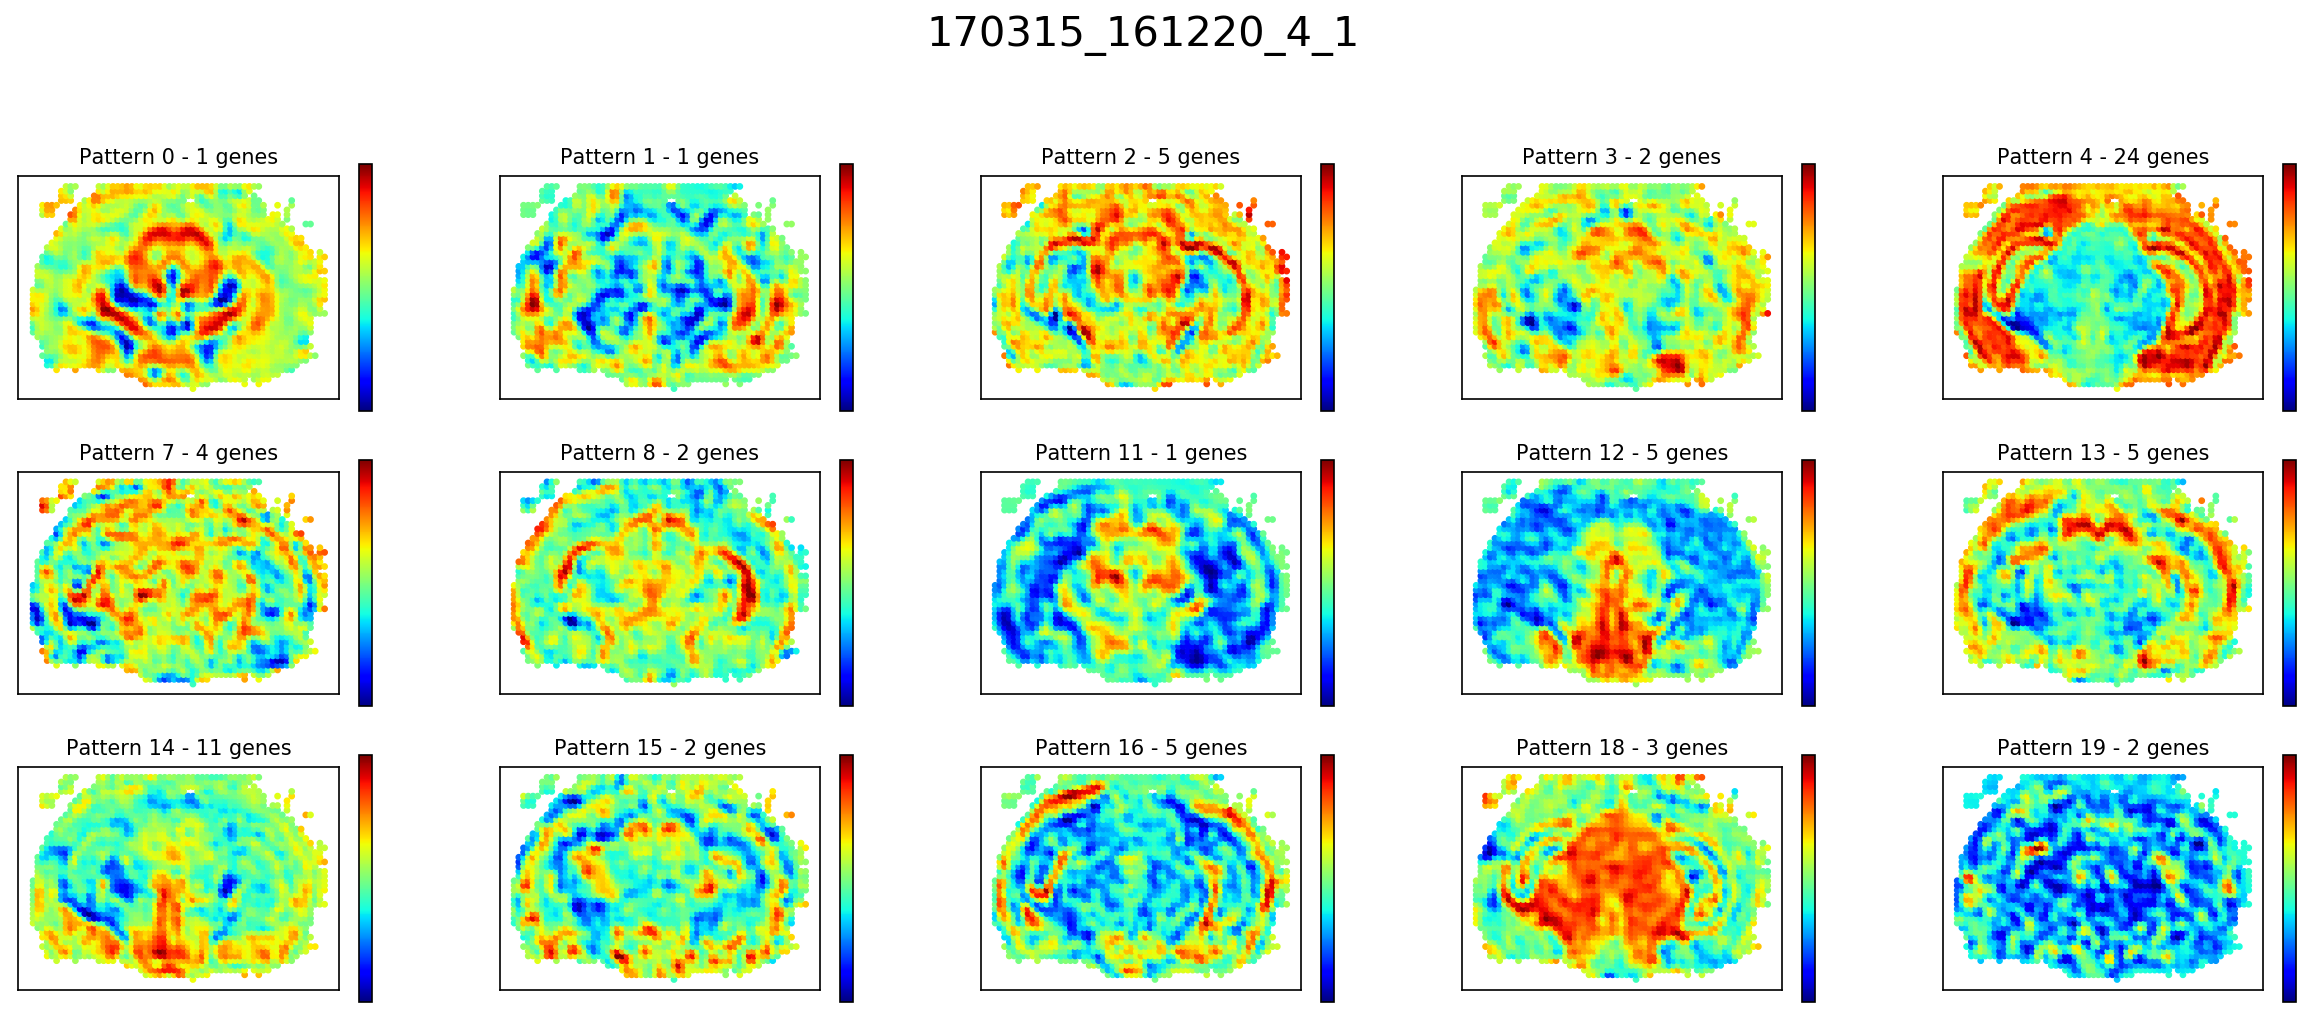

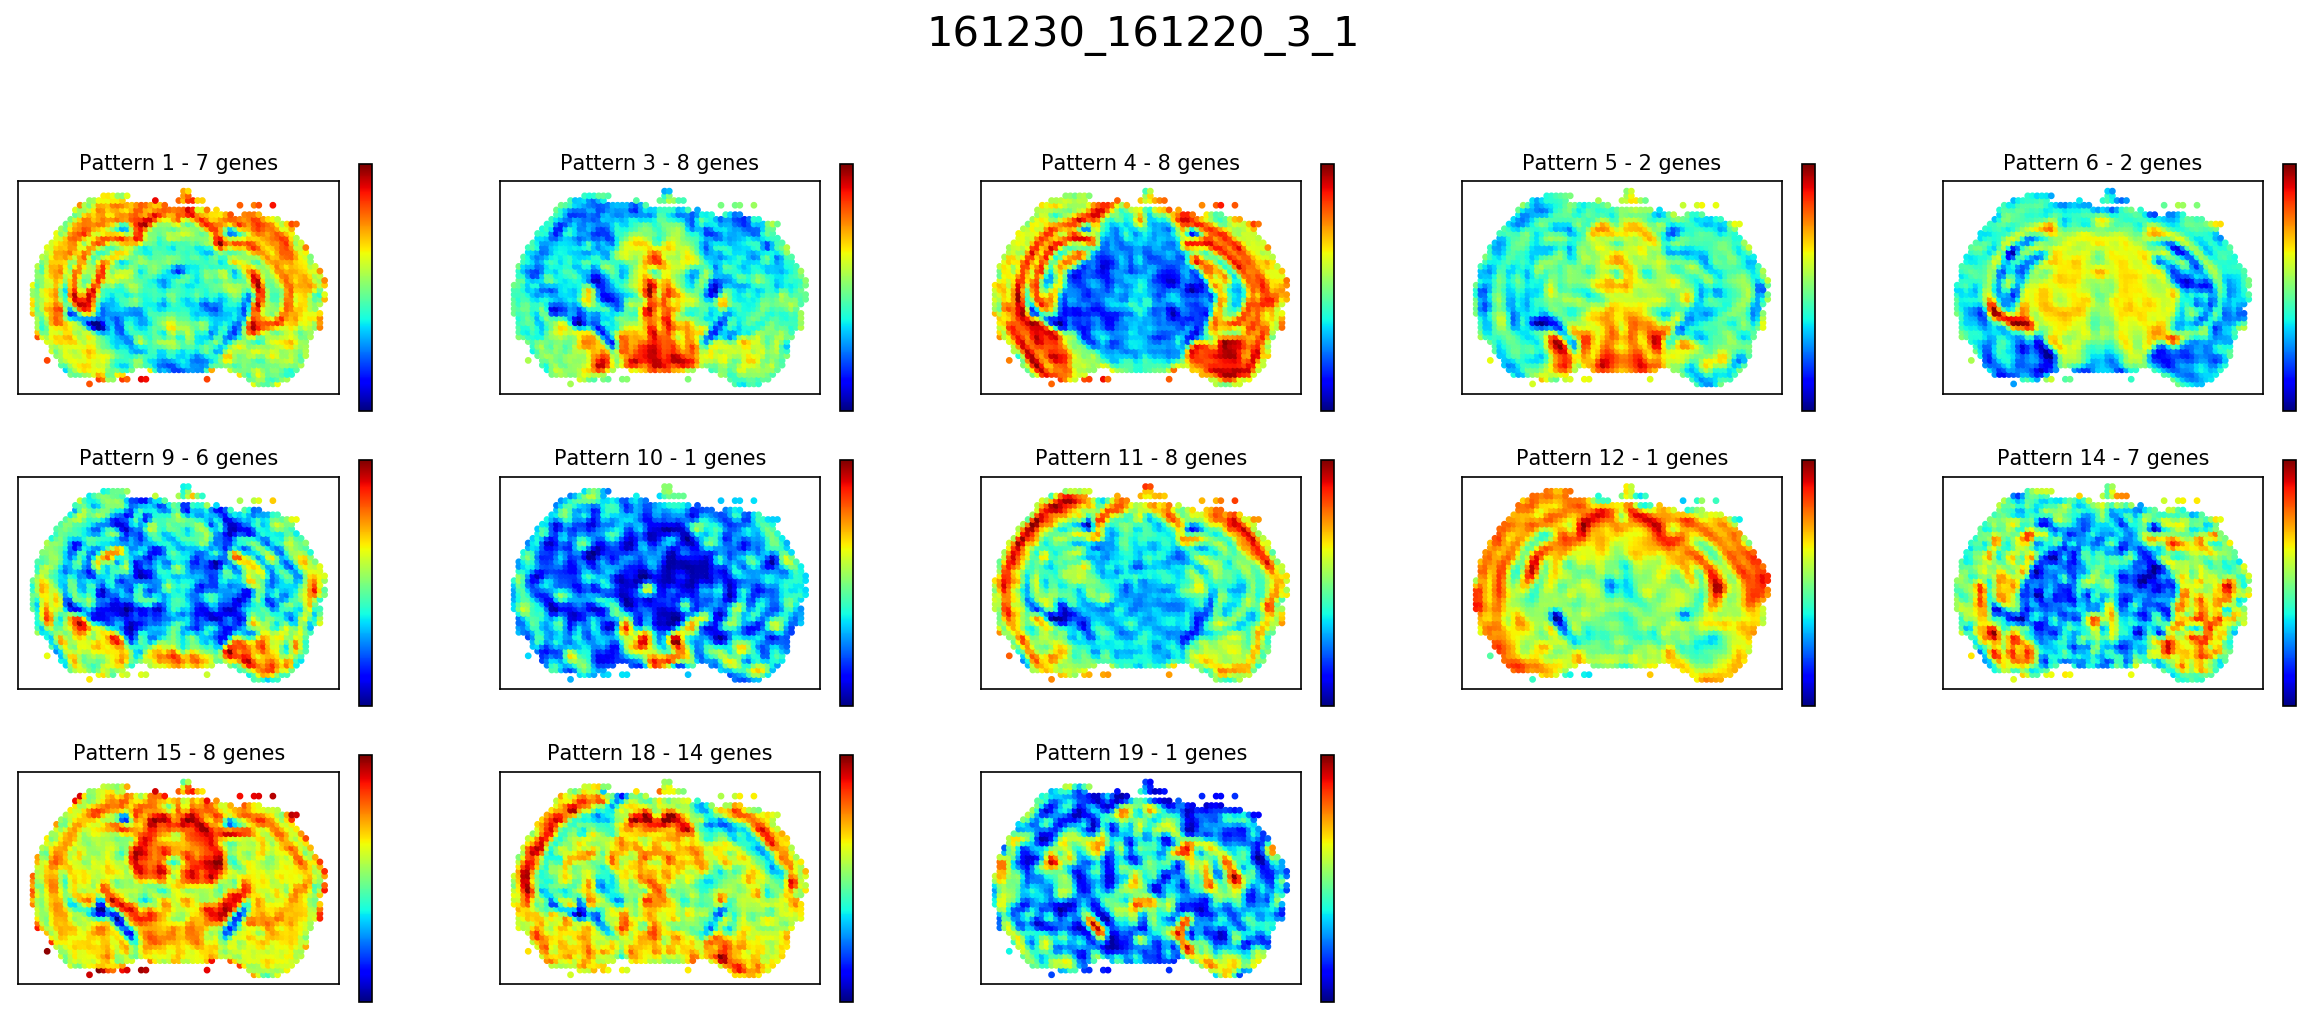

In [12]:
# Plot Histological Patterns
res = []
n_patterns = 20
for s,df in enumerate(datasets):
    res.append(pickle.load(open( "../data/results/"+df+"/SpatialDE_res.hdf5", "rb")))
    histology_results = res[s]['aeh']
    patterns = res[s]['patterns']
    plt.figure(figsize=(20,10))
    plt.suptitle(df,fontsize=20)
    j=1
    for i in range(n_patterns):
        if len(histology_results[histology_results.pattern==i])>0:
            plt.subplot(4, 5, j)
            plt.scatter(sample_df.loc[sample_df.s==s,'x'], sample_df.loc[sample_df.s==s,'y'], c=patterns[i], s=5,cmap='jet');
            plt.axis('scaled')
            plt.title('Pattern {} - {} genes'.format(i, histology_results.query('pattern == @i').shape[0]), fontsize=10)
            plt.colorbar(ticks=[]);
            plt.xticks([])
            plt.yticks([]);
            j = j+1

In [13]:
for i,df in enumerate(datasets):
    histology_results = res[i]['aeh']
    print(df)
    for i in histology_results.sort_values('pattern').pattern.unique():
        print('Pattern {}: '.format(i))
        print(', '.join(histology_results.query('pattern == @i').sort_values('membership')['g'].tolist()))
    print("\n")

170315_161220_4_1
Pattern 0: 
Gad1
Pattern 1: 
Rgs12
Pattern 2: 
Adgrl2, Atp1b1, Kit, Serpini1, Pvalb
Pattern 3: 
Reln, CdA3
Pattern 4: 
Calm2, Rgs4, Pde1a, Nrn1, Nov, Neurod6, Lamp5, Gda, Gabrd, Crym, Crhbp, Cck, Bcl11b, Arpp21, 3110035E14Rik, Vip, Rprm, Nr4a2, Htr3a, Enc1, Cox6a2, Cnr1, Satb1, Snca
Pattern 7: 
Plcxd2, Sema3c, Sulf2, Slc24a2
Pattern 8: 
Aldoc, Ndnf
Pattern 11: 
Chrm2
Pattern 12: 
Calb2, Scg2, Sncg, Tac1, Zcchc12
Pattern 13: 
Calb1, Cxcl14, Rorb, Thsd7a, Id2
Pattern 14: 
Fos, Grin3a, Nos1, Penk, Rasgrf2, Rgs10, Cpne5, Fxyd6, Gap43, Th, Wfs1
Pattern 15: 
Pcp4, Pthlh
Pattern 16: 
Fam19a1, Pvrl3, Tac2, Cux2, Npy2r
Pattern 18: 
Enpp2, Plp1, Slc6a1
Pattern 19: 
Kcnk2, Synpr


161230_161220_3_1
Pattern 1: 
Fos, Kit, Nrn1, Cck, Neurod6, Satb1, Slc24a2
Pattern 3: 
Nos1, Penk, Th, Calb2, Fxyd6, Gap43, Sncg, Zcchc12
Pattern 4: 
Rprm, 3110035E14Rik, Bcl11b, Crym, Enc1, Gda, Nov, Pde1a
Pattern 5: 
Scg2, Tac1
Pattern 6: 
Enpp2, Plp1
Pattern 9: 
CdA3, Npy2r, Synpr, Calb1, Cox6a2, Wf